In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

In [31]:
# Custom dataset class for loading waste images
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir  # Directory where images are stored
        self.transform = transform  # Transformations to be applied to images
        self.classes = sorted(os.listdir(root_dir))  # List of class names (subfolders in root_dir)
        self.image_paths = []  # List to store paths to images
        self.labels = []  # List to store labels corresponding to images
        
        # Loop through each class
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)  # Path to class folder
            for subfolder in ['default', 'real_world']:  # Iterate through subfolders
                subfolder_dir = os.path.join(class_dir, subfolder)  # Path to subfolder
                image_names = os.listdir(subfolder_dir)  # List of image file names
                random.shuffle(image_names)  # Shuffle images
                
                # Split images into training, validation, and test sets
                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]  # 60% for training
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]  # 20% for validation
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]  # 20% for testing
                
                # Add image paths and labels to lists
                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))  # Add full image path
                    self.labels.append(i)  # Add corresponding label
    
    def __len__(self):
        return len(self.image_paths)  # Return the total number of images
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]  # Get image path at given index
        label = self.labels[index]  # Get label at given index
        image = Image.open(image_path).convert('RGB')  # Open image and convert to RGB
        
        if self.transform:
            image = self.transform(image)  # Apply transformations if any
        
        return image, label  # Return the image and its label

In [32]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()  # Call the parent class (nn.Module) initializer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # First convolutional layer: 3 input channels (RGB), 32 output channels, 3x3 kernel
        self.relu = nn.ReLU()  # ReLU activation function
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer with 2x2 kernel and stride of 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Second convolutional layer: 32 input channels, 64 output channels, 3x3 kernel
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # First fully connected layer: input size 64*56*56, output size 512
        self.fc2 = nn.Linear(512, num_classes)  # Second fully connected layer: input size 512, output size num_classes
    
    def forward(self, x):
        x = self.conv1(x)  # Apply the first convolutional layer
        x = self.relu(x)  # Apply ReLU activation
        x = self.maxpool(x)  # Apply max pooling
        x = self.conv2(x)  # Apply the second convolutional layer
        x = self.relu(x)  # Apply ReLU activation
        x = self.maxpool(x)  # Apply max pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.fc1(x)  # Apply the first fully connected layer
        x = self.relu(x)  # Apply ReLU activation
        x = self.fc2(x)  # Apply the second fully connected layer
        return x  # Return the output


In [20]:
# Set the dataset path and hyperparameters
dataset_path = r'C:\Users\Schalk\OneDrive - Columbia Business School\Coding\000. data\images\images'
batch_size = 32
num_epochs = 5
learning_rate = 0.001

In [21]:
# Create the datasets and data loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = WasteDataset(dataset_path, split='train', transform=transform)
val_dataset = WasteDataset(dataset_path, split='val', transform=transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# Create the model, loss function, and optimizer
num_classes = len(train_dataset.classes)
model = CNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images
        labels = labels
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images
            labels = labels
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training completed!")

Epoch [1/5], Train Loss: 4.2327, Val Loss: 3.3960
Epoch [2/5], Train Loss: 3.0511, Val Loss: 2.4448
Epoch [3/5], Train Loss: 2.0250, Val Loss: 1.5090
Epoch [4/5], Train Loss: 0.7997, Val Loss: 1.0850
Epoch [5/5], Train Loss: 0.3066, Val Loss: 1.0826
Training completed!


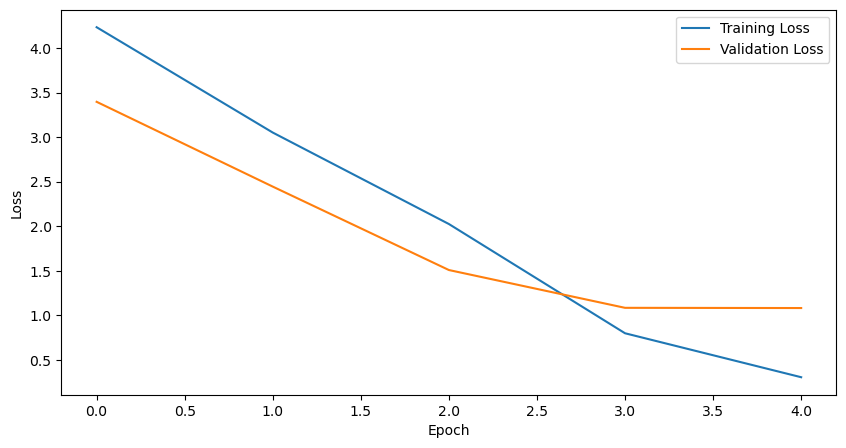

In [26]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


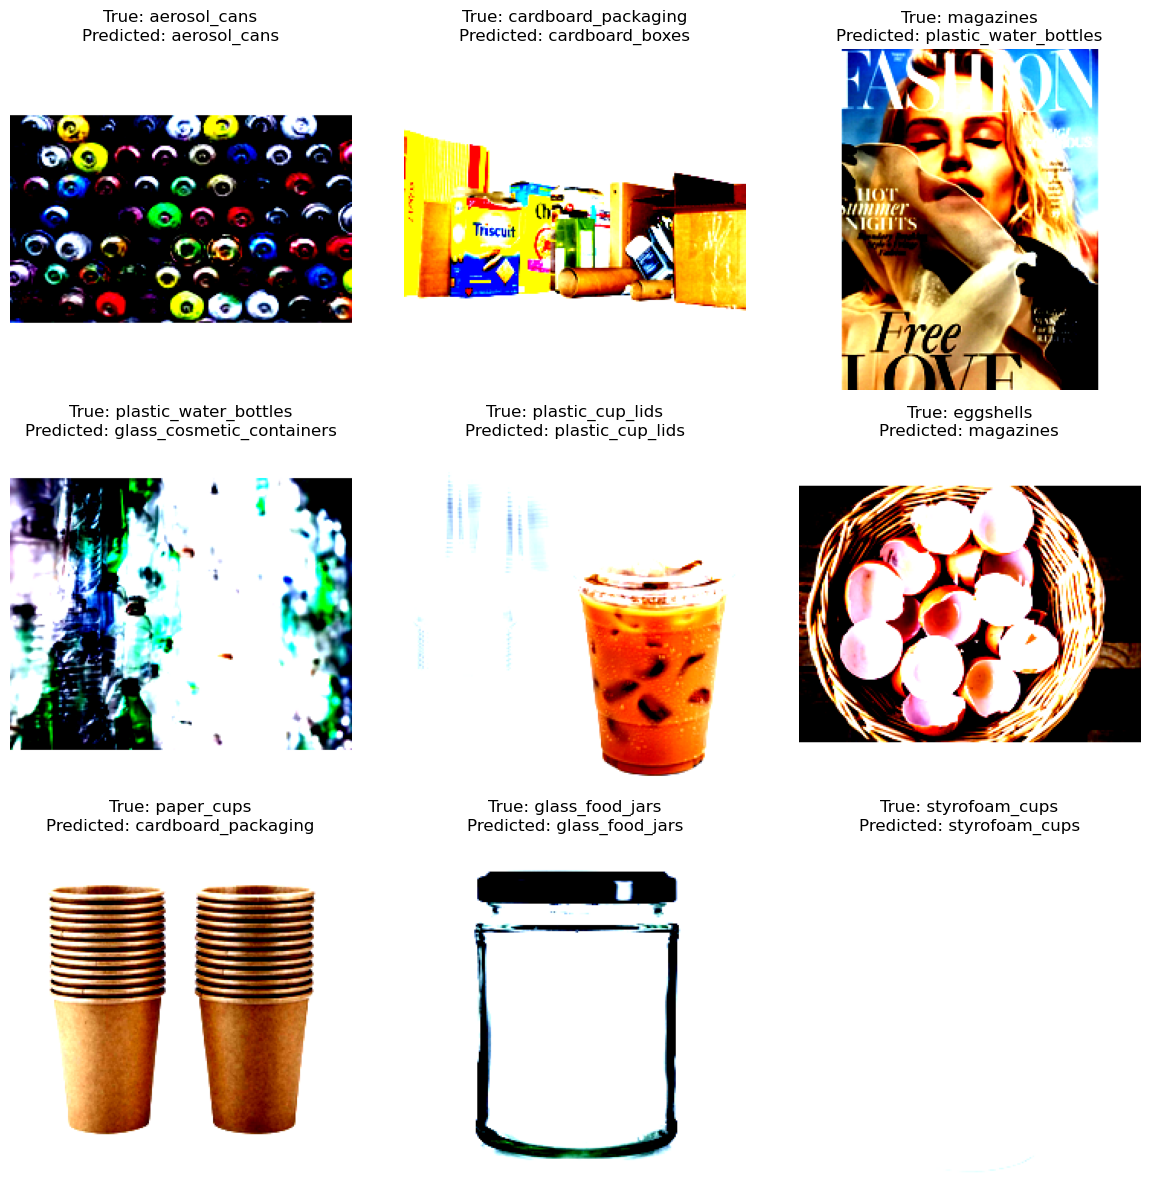

In [30]:
# Perform sample inferences on random test images with different labels
model.eval()
with torch.no_grad():
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)
    
    selected_images = []
    selected_labels = []
    selected_predicted = []
    
    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0)
        
        output = model(image)
        _, predicted = torch.max(output, 1)
        
        if label not in selected_labels:
            selected_images.append(image)
            selected_labels.append(label)
            selected_predicted.append(predicted.item())
        
        if len(selected_labels) == 9:
            break
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(9):
        axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))
        axes[i].set_title(f"True: {train_dataset.classes[selected_labels[i]]}\nPredicted: {train_dataset.classes[selected_predicted[i]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()